In [13]:
!pip install ultralytics

In [2]:
import cv2
from ultralytics import YOLO
from collections import defaultdict


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
model = YOLO('best.pt')                   # import the "best.pt" to  the colab's file section
print('fish detector model loaded succesfully ')

fish detector model loaded succesfully 


In [6]:
class_list = model.names
print(class_list)

{0: 'Coris julis', 1: 'Diplodus annulairs yed safra', 2: 'Diplodus sargus', 3: 'Diplodus vulgaris', 4: 'Spicara maena', 5: 'oblada melanura', 6: 'serranus cabrilla', 7: 'unknown fish'}


In [7]:
# Open the video file
cap = cv2.VideoCapture("input_m2.mp4")

Video loaded successfully!
First frame read successfully!


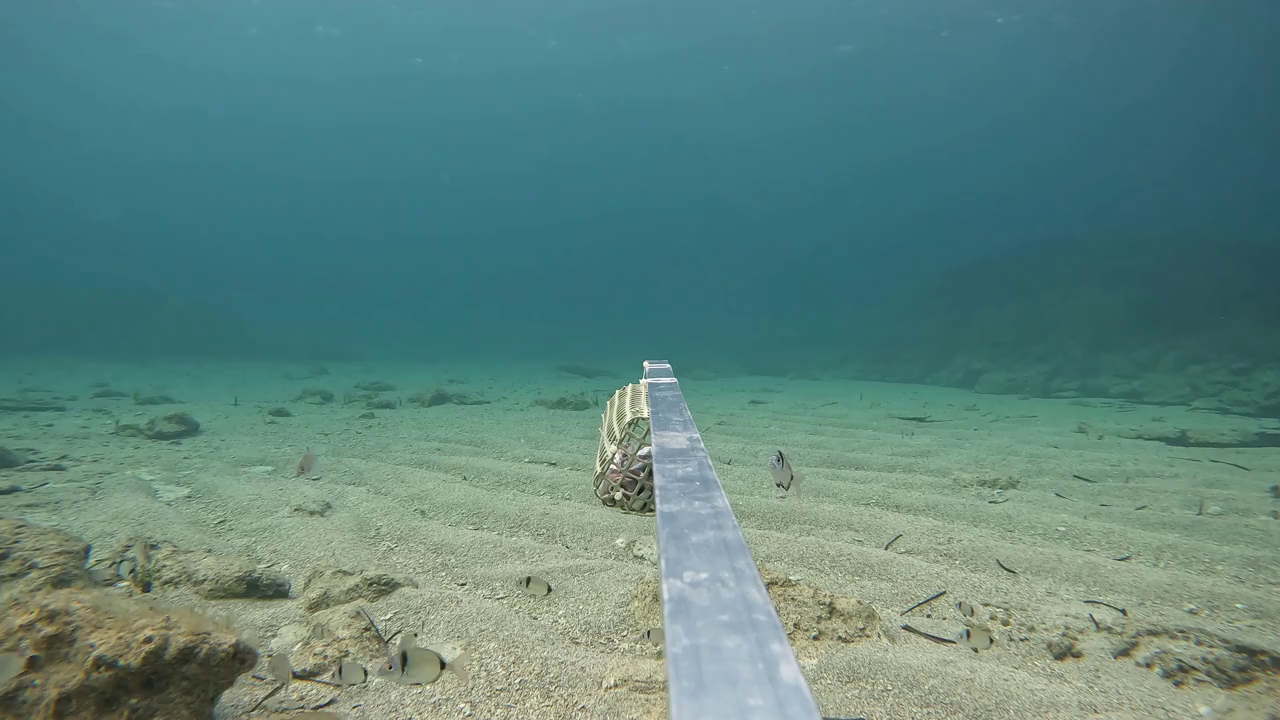

In [9]:
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture("input_m2.mp4")

if not cap.isOpened():
    print("Error: Video file not found or cannot be opened.")
else:
    print("Video loaded successfully!")

ret, frame = cap.read()
if ret:
    print("First frame read successfully!")
    cv2_imshow(frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Could not read the first frame.")


In [10]:
line_y_red = 430  # Red virtual-line position

# Dictionary to store object counts by class
class_counts = defaultdict(int)

# Dictionary to keep track of object IDs that have crossed the line
crossed_ids = set()

In [11]:
video_path = "input_m2.mp4"  # <- change if needed
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Cannot open video.")
    raise SystemExit()


In [ ]:

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

print("Video properties:", frame_width, "x", frame_height, "FPS:", fps)
out_path = "/content/drive/MyDrive/output_m2.mp4"
out = cv2.VideoWriter(
    out_path,
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (frame_width, frame_height)
)

# Two entry lines
left_line = 50
right_line = frame_width - 50

# Counting variables
class_counts = defaultdict(int)
crossed_ids = set()

# Process frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLO tracking on this frame
    results = model.track(frame, persist=True)

    if results[0].boxes.data is not None:
        boxes = results[0].boxes.xyxy.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        class_indices = results[0].boxes.cls.int().cpu().tolist()

        # Draw the two vertical entry lines
        cv2.line(frame, (left_line, 0), (left_line, frame_height), (0, 0, 255), 3)
        cv2.line(frame, (right_line, 0), (right_line, frame_height), (0, 0, 255), 3)

        # Process each detected fish
        for box, track_id, class_idx in zip(boxes, track_ids, class_indices):
            x1, y1, x2, y2 = map(int, box)
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2
            class_name = class_list[class_idx]

            # Draw bounding box + center + text
            cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"ID:{track_id} {class_name}",
                        (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                        (0, 255, 255), 2)

            # Count when entering from left side
            if cx > left_line and track_id not in crossed_ids:
                crossed_ids.add(track_id)
                class_counts[class_name] += 1

            # Count when entering from right side
            if cx < right_line and track_id not in crossed_ids:
                crossed_ids.add(track_id)
                class_counts[class_name] += 1

        # Display live counts
        y_offset = 30
        for cname, count in class_counts.items():
            cv2.putText(frame, f"{cname}: {count}",
                        (10, y_offset),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                        (0, 255, 0), 2)
            y_offset += 30

    # Write frame to output video
    out.write(frame)

# 8) Finish
cap.release()
out.release()

print("Tracking done! Video saved to:", out_path)


## Final counting results


In [14]:
import pandas as pd

final_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

print("\n====== FINAL COUNTS (per species) ======")
for species, count in final_counts:
    print(f"{species:25s} : {count}")

print("----------------------------------------")
print(f"TOTAL (all species)         : {sum(class_counts.values())}")
print(f"UNIQUE TRACK IDS COUNTED    : {len(crossed_ids)}")
print("========================================\n")

# 2) Display as a table (best in notebooks)
df_counts = pd.DataFrame(final_counts, columns=["species", "count"])
display(df_counts)


====== FINAL COUNTS (per species) ======
Diplodus vulgaris         : 34
Diplodus sargus           : 23
unknown fish              : 11
Coris julis               : 3
Diplodus annulairs yed safra : 3
Spicara maena             : 1
----------------------------------------
TOTAL (all species)         : 75
UNIQUE TRACK IDS COUNTED    : 75



,species,count
0,Diplodus vulgaris,34
1,Diplodus sargus,23
2,unknown fish,11
3,Coris julis,3
4,Diplodus annulairs yed safra,3
5,Spicara maena,1


Saved: final_counts.csv
